In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
from wordcloud import WordCloud
import re
import pickle

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.layers import GlobalMaxPool1D, Bidirectional, Dropout, Dense, LSTM
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

%run twitter.py
%run plot.py

## DATA COLLECTION

The dataset comes from CrowdFlower via data.world (Links to an external site.). Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neithe

https://data.world/crowdflower/brands-and-product-emotions

In [2]:
df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## DATA SCRUBBING

In [5]:
df.drop(labels=['emotion_in_tweet_is_directed_at'], inplace=True, axis=1)

In [6]:
df.columns=['tweet_raw', 'sentiment']

In [7]:
df.sentiment = df.sentiment.apply(lambda x: 'neutral' if x =='No emotion toward brand or product' else x.lower())
df.sentiment = df.sentiment.apply(lambda x: 'positive' if x =='positive emotion' else x.lower())
df.sentiment = df.sentiment.apply(lambda x: 'negative' if x =='negative emotion' else x.lower())

In [8]:
df.dropna(inplace=True)

In [9]:
df.head()

,tweet_raw,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,positive
3,@sxsw I hope this year's festival isn't as cra...,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,positive


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_raw  9092 non-null   object
 1   sentiment  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


## PREPROCESSING

In [11]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package words to /Users/boula/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/boula/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/boula/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/boula/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
stop_words=stopwords.words('english')

In [12]:
urls = url_extractor(df.tweet_raw)

In [13]:
hashtag_list = hashtags(df.tweet_raw)

In [14]:
df['tweet'] = CleanUp(df.tweet_raw)

In [15]:
tokenizer = RegexpTokenizer('[a-zA-Z0-9]+')
df.tweet  =  df.tweet.apply(lambda x: tokenizer.tokenize(x))

In [16]:
stop_words_en = set(stopwords.words('english'))
df.tweet      = df.tweet.apply(lambda tweet: [word for word in tweet if word not in stop_words_en])

In [17]:
lemmatizer = WordNetLemmatizer()
df.tweet   = df.tweet.apply(lambda tweet: [lemmatizer.lemmatize(word) for word in tweet])

In [18]:
df.tweet = df.tweet.apply(lambda tweet: ' '.join(tweet))

## FEATURES ENGINEERING

In [19]:
twitt = Twitter(df.tweet)

In [20]:
df['lexical_diversity']= twitt.Lexical_Diversity

In [21]:
df['word_count'] = twitt.WordsCount

## EXPLORATORY DATA ANALYSIS

In [23]:
tdf = df.groupby(['sentiment'], as_index=False).count().reset_index(drop=True).\
sort_values(by='tweet_raw', ascending=False).style.background_gradient(cmap='Purples')
tdf

,sentiment,tweet_raw,tweet,lexical_diversity,word_count
2,neutral,5388,5388,5388,5388
3,positive,2978,2978,2978,2978
1,negative,570,570,570,570
0,i can't tell,156,156,156,156


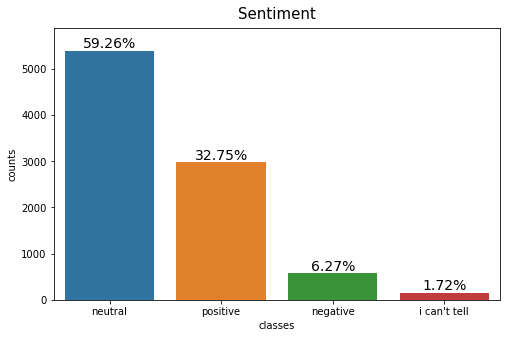

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
g = sns.barplot(x=df.sentiment.value_counts().index,
                 y=df.sentiment.value_counts().values, ax=ax)
for index, row in df.sentiment.value_counts().iteritems():
    g.text(x=df.sentiment.value_counts().index.get_loc(index),
            y=row,
            s='{0:.2f}%'.format(row/df.shape[0]*100),
            color='black', fontsize=14, horizontalalignment='center', va='bottom')
ax.set_ylim((0, df.sentiment.value_counts().max()+500))
ax.set_title("Sentiment", fontsize=15, ha='center', va='bottom')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
plt.savefig('./img/sentiment_classes.jpg',format="jpg")
plt.show()

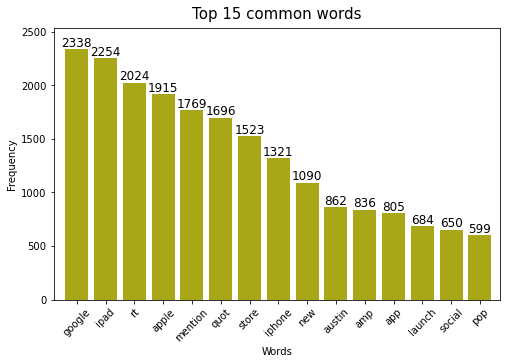

In [25]:
df_freq = pd.DataFrame(twitt.FrequencyDist.items(), columns=['word','counts'])
fig, ax = plt.subplots(figsize=(8,5))
sns_word_freq = sns.barplot(x=df_freq.word.head(15), y=df_freq.counts.head(15), data=df_freq, color='y')
for idx, row in df_freq.head(15).iterrows():
    sns_word_freq.text(x=row.name, y=row.counts, s=round(row.counts),
                       color='black', va='bottom',  ha="center", fontsize=12)
ax.set_xlim((-0.8, 14.7))
ax.set_ylim((0, df_freq.head(15).counts.max()+200))
ax.set_title('Top 15 common words', fontsize=15, ha='center', va='bottom')
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('./img/word_frequency.jpg',format="jpg")
plt.show()

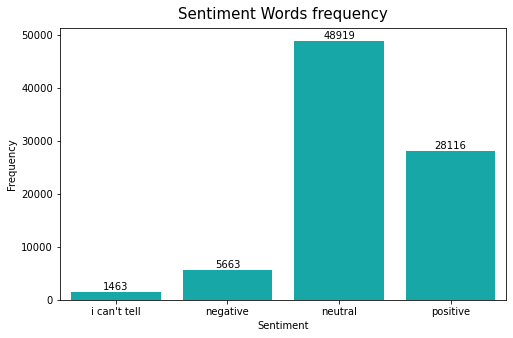

In [26]:
df_word_count = df.groupby('sentiment', as_index=False).agg({'word_count': 'sum'})
fig, ax = plt.subplots(figsize=(8,5))
sns_word_count = sns.barplot(x='sentiment', y='word_count', data=df_word_count, color='c')
for idx, row in df_word_count.iterrows():
    sns_word_count.text(x=row.name, y=row.word_count, s=round(row.word_count),
                        color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("Sentiment Words frequency", fontsize=15, ha='center', va='bottom')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
plt.savefig('./img/word_count_frequency.jpg',format="jpg")
plt.show()

In [27]:
df_hashtag_all = pd.DataFrame(hashtags(df.tweet_raw).items(), columns=['hashtag', 'count'])
df_hashtag_pos = pd.DataFrame(hashtags(df[(df.sentiment=='positive')].tweet_raw).items(), columns=['hashtag','count'])
df_hashtag_neg = pd.DataFrame(hashtags(df[(df.sentiment=='negative')].tweet_raw).items(), columns=['hashtag','count'])

<AxesSubplot:xlabel='hashtag', ylabel='count'>

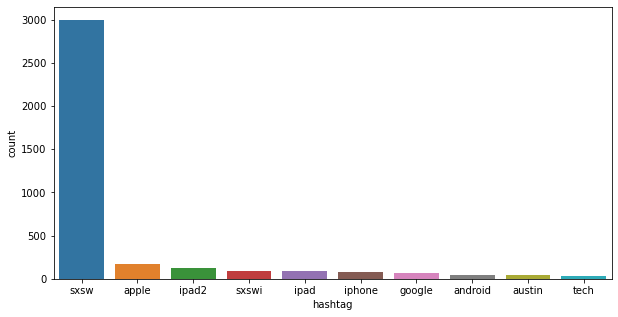

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

# sns.barplot(x='hashtag', y='count', data=df_hashtag_all.head(10))
sns.barplot(x='hashtag', y='count', data=df_hashtag_pos.head(10))
# sns.barplot(x='hashtag', y='count', data=df_hashtag_all.head(10))

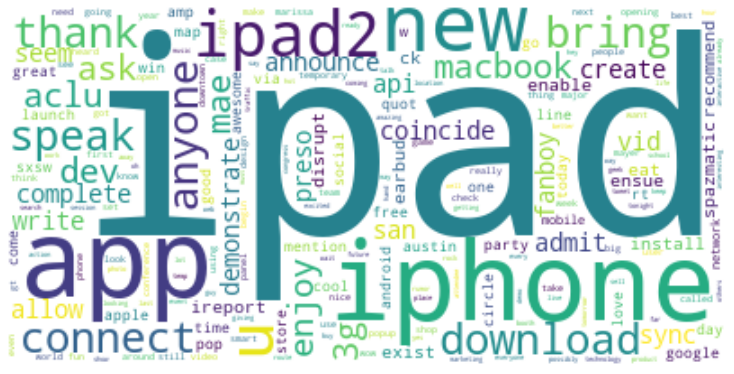

In [29]:
positive = Twitter(df[(df.sentiment=='positive')].tweet)

WC1= WordCloud(
    max_font_size=150,
    background_color="white",
    ranks_only=True
).generate(text= ' '.join([k for k in positive.FrequencyDist.keys()]) )

plt.figure(figsize=(10,7), facecolor='w')
plt.imshow(WC1, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('./img/word_cloud_positive.jpg',format="jpg")
plt.show()

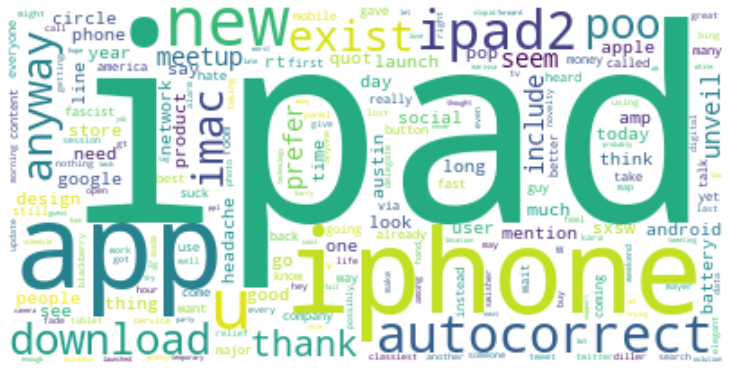

In [30]:
negative = Twitter(df[(df.sentiment=='negative')].tweet)

WC2= WordCloud(
    max_font_size=150,
    background_color="white",
    ranks_only=True
).generate(text= ' '.join([k for k in negative.FrequencyDist.keys()]) )

plt.figure(figsize=(10,7), facecolor='w')
plt.imshow(WC2, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('./img/word_cloud_negative.jpg',format="jpg")
plt.show()

## Modeling

In [22]:
ohe = OneHotEncoder(sparse=False)
Y_ohe = ohe.fit_transform(df.sentiment.values.reshape(-1,1))
print(f"{'Y_ohe Categories:':20}{ohe.categories_[0]}")
print(f"{'Y_ohe Shape':20}{Y_ohe.shape}")

Y_ohe Categories:   ["i can't tell" 'negative' 'neutral' 'positive']
Y_ohe Shape         (9092, 4)


In [24]:
Test_Size = int(df.shape[0]*.15)

tfidfVectorizer = TfidfVectorizer(max_features=10_000,
                                  norm='l1', 
                                  strip_accents='ascii',
                                  stop_words=stop_words,
                                  analyzer='word',
                                  ngram_range=(1,1))
X_train, X_test, y_train, y_test = train_test_split(df.tweet, Y_ohe, test_size=Test_Size, random_state=67)
X_train   = tfidfVectorizer.fit_transform(X_train)
X_train   = X_train.toarray()
X_test    = tfidfVectorizer.transform(X_test)
X_test    = X_test.toarray()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=Test_Size, random_state=67)

print(f"Train\n\t{'X :':5}{X_train.shape}\n\t{'Y :':5}{y_train.shape}")
print(f"Test\n\t{'X :':5}{X_test.shape}\n\t{'Y :':5}{y_test.shape}")
print(f"Validation\n\t{'X :':5}{X_val.shape}\n\t{'Y :':5}{y_val.shape}")

Train
	X :  (6366, 7045)
	Y :  (6366, 4)
Test
	X :  (1363, 7045)
	Y :  (1363, 4)
Validation
	X :  (1363, 7045)
	Y :  (1363, 4)


In [25]:
eStop_Val_Loss = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=24,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Loss     = EarlyStopping(monitor='loss', min_delta=0.001, patience=24,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_AUC      = EarlyStopping(monitor='auc', min_delta=0.001, patience=24,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)
eStop_Val_AUC  = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=50,
                            verbose=1, mode='max', baseline=0.999, restore_best_weights=False)

In [26]:
METRICS1 = ['AUC']
EPOCHS = 128
BATCH_SIZE = 2048

## Baseline model

In [78]:
keras.backend.clear_session()

In [94]:
model1 = make_model(metrics=METRICS1,
                    input_shape=X_train.shape[1],
                    output_shape=y_train.shape[1],
                    bias_initializer=tf.keras.initializers.zeros,
                    kernel_initializer=keras.initializers.GlorotUniform(),
                    optimizer=keras.optimizers.Adam(learning_rate=0.001)
                   )
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input32 (Dense)              (None, 64)                450944    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense16 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense8 (Dense)               (None, 8)                 136       
_________________________________________________________________
output4 (Dense)              (None, 4)                 36        
Total params: 452,156
Trainable params: 452,156
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model1.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=X_train.shape[0],
#                     callbacks=[eStop_val_loss],
                    use_multiprocessing = True,
                    workers=8
                    )

Epoch 1/128
1/1 [==============================] - 1s 1s/step - loss: 1.3742 - auc: 0.5652 - val_loss: 1.3620 - val_auc: 0.5780
Epoch 2/128
1/1 [==============================] - 0s 454ms/step - loss: 1.3707 - auc: 0.5664 - val_loss: 1.3589 - val_auc: 0.5784
Epoch 3/128
1/1 [==============================] - 0s 439ms/step - loss: 1.3675 - auc: 0.5667 - val_loss: 1.3554 - val_auc: 0.5795
Epoch 4/128
1/1 [==============================] - 0s 431ms/step - loss: 1.3642 - auc: 0.5697 - val_loss: 1.3517 - val_auc: 0.5787
Epoch 5/128
1/1 [==============================] - 0s 421ms/step - loss: 1.3607 - auc: 0.5701 - val_loss: 1.3477 - val_auc: 0.5790
Epoch 6/128
1/1 [==============================] - 0s 417ms/step - loss: 1.3569 - auc: 0.5699 - val_loss: 1.3436 - val_auc: 0.5793
Epoch 7/128
1/1 [==============================] - 0s 447ms/step - loss: 1.3529 - auc: 0.5707 - val_loss: 1.3393 - val_auc: 0.5815
Epoch 8/128
1/1 [==============================] - 0s 421ms/step - loss: 1.3488 - auc:

In [101]:
model1.save_weights(filepath='./tfidf_model/model1')

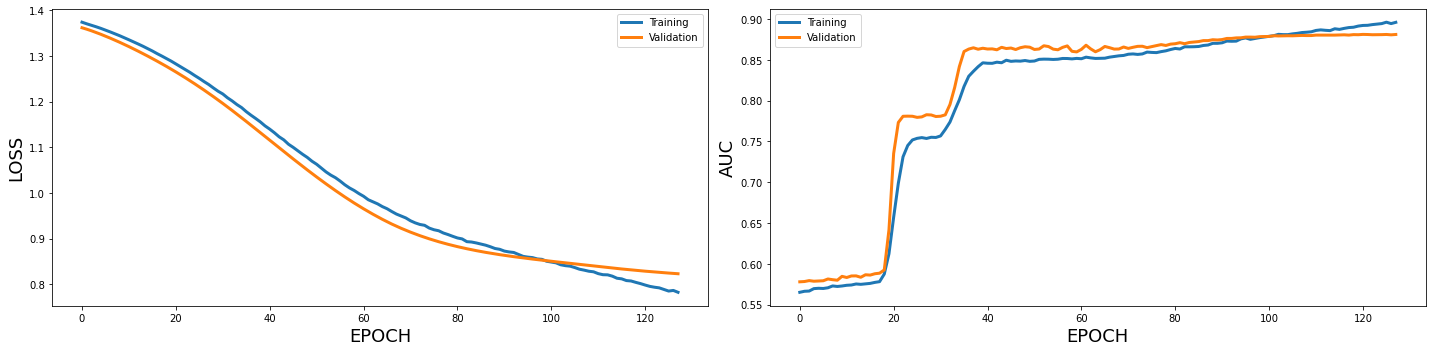

In [100]:
plot_history(history)

## Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

In [ ]:
%run twitter.py

In [104]:
model1 = make_model(metrics=METRICS1,
                    input_shape=X_train.shape[1],
                    output_shape=y_train.shape[1],
                    bias_initializer=tf.keras.initializers.Zeros(),
                    kernel_initializer=keras.initializers.GlorotUniform(),
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    output_bias=baias
                   )
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input32 (Dense)              (None, 64)                450944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense16 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense8 (Dense)               (None, 8)                 136       
_________________________________________________________________
output4 (Dense)              (None, 4)                 36        
Total params: 452,156
Trainable params: 452,156
Non-trainable params: 0
_________________________________________________________________


In [105]:
history = model1.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    #callbacks=[eStop_LOSS],
                    use_multiprocessing = True,
                    workers=8
                    )

Epoch 1/128
3/3 [==============================] - 1s 240ms/step - loss: 14.1519 - auc: 0.3446 - val_loss: 14.2370 - val_auc: 0.3417
Epoch 2/128
3/3 [==============================] - 0s 162ms/step - loss: 14.1389 - auc: 0.3448 - val_loss: 14.2242 - val_auc: 0.3417
Epoch 3/128
3/3 [==============================] - 0s 160ms/step - loss: 14.1296 - auc: 0.3448 - val_loss: 14.2103 - val_auc: 0.3417
Epoch 4/128
3/3 [==============================] - 0s 158ms/step - loss: 14.0901 - auc: 0.3451 - val_loss: 14.1949 - val_auc: 0.3417
Epoch 5/128
3/3 [==============================] - 0s 160ms/step - loss: 14.1158 - auc: 0.3435 - val_loss: 14.1778 - val_auc: 0.3417
Epoch 6/128
3/3 [==============================] - 0s 162ms/step - loss: 14.0654 - auc: 0.3450 - val_loss: 14.1584 - val_auc: 0.3417
Epoch 7/128
3/3 [==============================] - 0s 160ms/step - loss: 14.0435 - auc: 0.3451 - val_loss: 14.1367 - val_auc: 0.3417
Epoch 8/128
3/3 [==============================] - 0s 159ms/step - lo

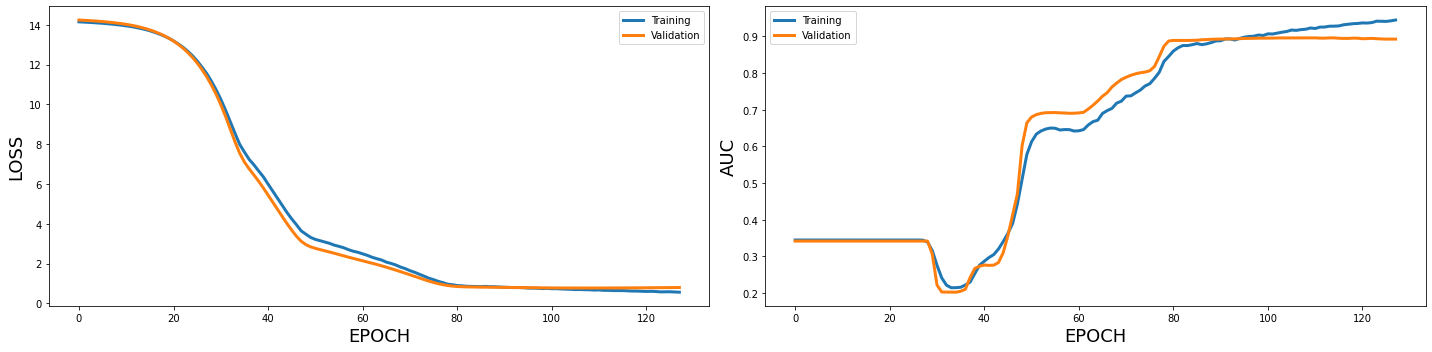

In [106]:
plot_history(history)

In [107]:
# model1.save_weights(filepath='./tfidf_model/model2')

In [30]:
model1 = make_model(metrics=METRICS1,
                    input_shape=X_train.shape[1],
                    output_shape=y_train.shape[1],
                    bias_initializer=tf.keras.initializers.Zeros(),
                    kernel_initializer=keras.initializers.GlorotUniform(),
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    output_bias=None
                   )
model1.load_weights(filepath='./tfidf_model/model2')

In [40]:
model1_score = model1.evaluate(X_test, y_test, batch_size=1, verbose=0)
print('AUC Score : ', model1_score[1])

AUC Score :  0.8718721866607666


In [44]:
model1_y_pred = model1.predict(X_test, batch_size=1)

In [45]:
cm = confusion_matrix(y_test.argmax(axis=1), model1_y_pred.argmax(axis=1))

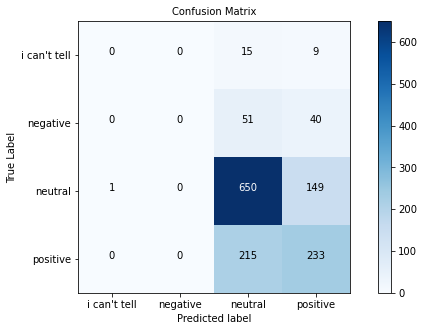

In [46]:
PlotConfusionMatrix(cm, ohe.categories_[0], FileName='./img/model1_cm.jpg')

## Recurrent Neural Networks

In [49]:
l_encoder = LabelEncoder()
Y_true = l_encoder.fit_transform(df.sentiment)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df.tweet)
sequences = tokenizer.texts_to_sequences(df.tweet)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=100)
labels = to_categorical(np.asarray(Y_true))

print(f"{'Unique Words':25} {len(word_index)}")
print(f"{'Shape of data tensor':25} {data.shape}")
print(f"{'Shape of label tensor':25} {labels.shape}")
# print(labels)

Unique Words              7570
Shape of data tensor      (9092, 100)
Shape of label tensor     (9092, 4)


In [50]:
Test_Size = int(data.shape[0]*.2)

X_train1, X_test1, y_train1, y_test1 = train_test_split(data, labels, test_size=Test_Size, random_state=67)

X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=Test_Size, random_state=67)

print(f"Train\n\t{'X :':5}{X_train1.shape}\n\t{'Y :':5}{y_train1.shape}")
print(f"Test\n\t{'X :':5}{X_test1.shape}\n\t{'Y :':5}{y_test1.shape}")
print(f"Validation\n\t{'X :':5}{X_val1.shape}\n\t{'Y :':5}{y_val1.shape}")

Train
	X :  (5456, 100)
	Y :  (5456, 4)
Test
	X :  (1818, 100)
	Y :  (1818, 4)
Validation
	X :  (1818, 100)
	Y :  (1818, 4)


Since we have our train-validation split ready, our next step is to create an embedding matrix from the precomputed Glove embeddings

GloVe model "Twitter" pre-trained word vectors can be downloaded by the following link:

https://nlp.stanford.edu/projects/glove/

In [596]:
#Generate a dictionary with glove vocabs as key and coefficients as numpy array
embeddings_index = dict()
twitter_27B_25d = open("./glove/glove.twitter.27B.25d.txt")
for line in twitter_27B_25d:
    values = line.split()
    vocab = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[vocab] = coefs
twitter_27B_25d.close()

In [597]:
# create a matrix of zeros with the size of of 'Word_index + 1 to match the input dimension of Embedding layer
oov_list = []
embedding_matrix = np.zeros((len(word_index) + 1, len(embeddings_index[next(iter(embeddings_index))])))
for word, idx in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        oov_list.append(word)
with open('./glove/embedding_matrix.pkl', 'wb') as eFile:
    pickle.dump(embedding_matrix, eFile)
    eFile.close()
print('Embedding Matrix shape ', embedding_matrix.shape)

Embedding Matrix shape  (7573, 25)


In [51]:
with open('./glove/embedding_matrix.pkl', 'rb') as eFile:
    embedding_matrix = pickle.load(eFile)

In [52]:
InputDim = embedding_matrix.shape[0]
EmbeddinDim = embedding_matrix.shape[1]
MaxSequenceLenght = data.shape[1]

In [53]:
ClassWeights, SampleWeights = ohe_weights(y_train1)
bias = [x for x in ClassWeights.values()]

In [54]:
# filepath = './tfidf_model/model.{epoch:02d}-{val_loss:.2f}.h5'
filepath = './glove/model2.cptk'
CP_AUC=[
    ModelCheckpoint(filepath=filepath, monitor='val_auc',
                    save_best_only=False,save_weights_only=True,mode='max', save_freq=0),
    EarlyStopping(monitor='val_auc', min_delta=0.0001, patience=15,
                  verbose=1,mode='max',baseline=0.9999,restore_best_weights=False)
]

In [55]:
eStop_AUC       = EarlyStopping(monitor='auc', min_delta=0.0001, patience=15,
                             verbose=1,mode='max',baseline=0.9999,restore_best_weights=False)
eStop_Val_AUC   = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=15,
                             verbose=1,mode='max',baseline=0.999,restore_best_weights=False)
eStop_TP        = EarlyStopping(monitor='TP', min_delta=0.0001, patience=24,
                            verbose=1,mode='max',baseline=0.999,restore_best_weights=False)
eStop_TN        = EarlyStopping(monitor='TN', min_delta=0.001, patience=24,
                            verbose=1,mode='max',baseline=0.999,restore_best_weights=False)
eStop_FP        = EarlyStopping(monitor='FP', min_delta=0.001, patience=24,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_FN        = EarlyStopping(monitor='FN', min_delta=0.001, patience=24,
                            verbose=1,mode='min',baseline=0.999,restore_best_weights=False)
eStop_Reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.000001, verbose=1)

In [56]:
METRICS2 = [keras.metrics.AUC(name='auc')]
EPOCHS = 128
BATCH_SIZE = 128
STEPS_x_EPOCH = X_train1.shape[0]//BATCH_SIZE

## Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

In [60]:
keras.backend.clear_session()

In [61]:
model2=make_embedding_model(Metrics=METRICS,
                            Optimizer=keras.optimizers.Adam(),
                            Input_Dim=InputDim,
                            EmbeddinDim=EmbeddinDim,
                            Weights=embedding_matrix,
                            Input_Length=MaxSequenceLenght,
                            Output_Bias=None)
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 25)           189325    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 50)           10200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                4288      
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 4)                 68        
Total params: 204,153
Trainable params: 14,828
Non-trainable params: 189,325
_____________________________________________

In [62]:
model2.layers[0].embeddings_initializer = keras.initializers.GlorotUniform()
model2.layers[-1].bias.assign([x for x in ClassWeights.values()])
model2.layers[3].activation = tf.keras.activations.swish

In [757]:
history = model2.fit(X_train1,
                    y_train1,
                    validation_data=(X_val1, y_val1),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_x_EPOCH,
                    callbacks=CP_AUC,
                    use_multiprocessing = True,
                    workers=6
                    )

Epoch 1/128
42/42 [==============================] - 14s 235ms/step - loss: 11.8230 - auc: 0.3449 - val_loss: 7.5637 - val_auc: 0.3419
Epoch 2/128
42/42 [==============================] - 8s 197ms/step - loss: 5.8153 - auc: 0.3712 - val_loss: 1.2597 - val_auc: 0.7063
Epoch 3/128
42/42 [==============================] - 8s 192ms/step - loss: 2.8103 - auc: 0.5787 - val_loss: 0.9830 - val_auc: 0.8257
Epoch 4/128
42/42 [==============================] - 8s 192ms/step - loss: 2.3503 - auc: 0.6525 - val_loss: 0.9893 - val_auc: 0.8281
Epoch 5/128
42/42 [==============================] - 8s 192ms/step - loss: 2.0368 - auc: 0.6863 - val_loss: 0.9828 - val_auc: 0.8252
Epoch 6/128
42/42 [==============================] - 8s 199ms/step - loss: 1.9464 - auc: 0.6945 - val_loss: 0.9875 - val_auc: 0.8282
Epoch 7/128
42/42 [==============================] - 8s 195ms/step - loss: 1.7001 - auc: 0.7278 - val_loss: 0.9960 - val_auc: 0.8268
Epoch 8/128
42/42 [==============================] - 8s 198ms/step 

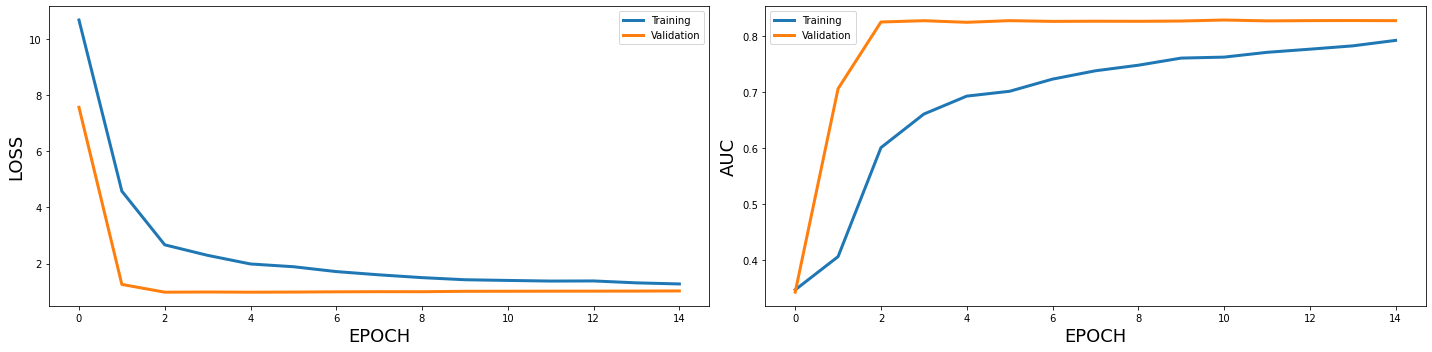

In [764]:
Plot_History(history)

In [766]:
model2.save_weights('./glove/model2_auc')

In [74]:
keras.backend.clear_session()

In [57]:
METRICS2 = [keras.metrics.AUC(name='auc'), keras.metrics.TruePositives(name='TP'), keras.metrics.TrueNegatives(name='TN')]
EPOCHS = 128
BATCH_SIZE = 128
STEPS_x_EPOCH = X_train1.shape[0]//BATCH_SIZE

In [58]:
model2=make_embedding_model(Metrics=METRICS2,
                            Optimizer=keras.optimizers.Adam(),
                            Input_Dim=InputDim,
                            EmbeddinDim=EmbeddinDim,
                            Weights=embedding_matrix,
                            Input_Length=MaxSequenceLenght,
                            Output_Bias=None)

model2.layers[0].embeddings_initializer = keras.initializers.GlorotUniform()
model2.layers[3].activation = tf.keras.activations.swish
model2.load_weights('./glove/model2_auc')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 25)           189325    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 50)           10200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                4288      
_________________________________________________________________
dense16 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
output4 (Dense)              (None, 4)                 68        
Total params: 204,153
Trainable params: 14,828
Non-trainable params: 189,325
___________________________________________

In [43]:
history = model2.fit(X_train1,
                    y_train1,
                    validation_data=(X_val1, y_val1),
                    validation_split=0.1,
                    validation_batch_size=1,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_x_EPOCH,
                    callbacks=[eStop_TP, eStop_TN],
                    use_multiprocessing = True,
                    workers=6
                    )

Epoch 1/128
42/42 [==============================] - 14s 226ms/step - loss: 1.3348 - auc: 0.7827 - TP: 1154.0233 - TN: 7372.3488 - val_loss: 1.0275 - val_auc: 0.8281 - val_TP: 322.0000 - val_TN: 1414.0000
Epoch 2/128
42/42 [==============================] - 7s 174ms/step - loss: 1.2542 - auc: 0.7954 - TP: 1237.1163 - TN: 7387.1628 - val_loss: 1.0327 - val_auc: 0.8286 - val_TP: 322.0000 - val_TN: 1414.0000
Epoch 3/128
42/42 [==============================] - 7s 174ms/step - loss: 1.3724 - auc: 0.7879 - TP: 1245.7442 - TN: 7351.9070 - val_loss: 1.0244 - val_auc: 0.8296 - val_TP: 322.0000 - val_TN: 1414.0000
Epoch 4/128
42/42 [==============================] - 7s 175ms/step - loss: 1.2593 - auc: 0.7958 - TP: 1225.3256 - TN: 7375.8140 - val_loss: 1.0296 - val_auc: 0.8290 - val_TP: 322.0000 - val_TN: 1414.0000
Epoch 5/128
42/42 [==============================] - 7s 174ms/step - loss: 1.3407 - auc: 0.7974 - TP: 1254.5581 - TN: 7373.9535 - val_loss: 1.0279 - val_auc: 0.8286 - val_TP: 322.0000

In [59]:
model2_score = model2.evaluate(X_test1, y_test1, batch_size=1, verbose=0)
print('AUC Accuracy :', model2_score[1])

AUC Accuracy : 0.8272119164466858


In [60]:
model2_y_pred = model2.predict(X_test1, batch_size=1, verbose=1)

1818/1818 [==============================] - 15s 8ms/step


In [61]:
cm_model2 = confusion_matrix(y_test1.argmax(axis=1), model2_y_pred.argmax(axis=1))

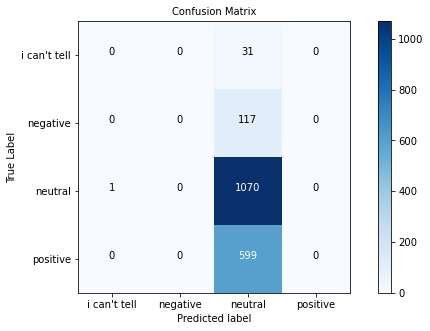

In [62]:
PlotConfusionMatrix(cm_model2, ohe.categories_[0], FileName='./img/model2_cm.jpg')

## Interpretation

- For the first model we used a simple Deep Neural Network with TF-IDF Vectorizer which results 87% of AUC accuracy but didn't able to predict more than 2 classes.

- The GloVe Embedding model constructed with Recurrent Neural Networks got less performance with 82% AUC accuracy.

- the overall result is not so much bad, dealing with a highly imbalanced dataset where the classe are respectively represented by 59.26%, 32.75% 6.27% and 1.72%, ML models wouldn't be able to learn. essentially we would need to have sufficiently large data to get better results.

## Conclusion

- For the first model we used a simple Deep Neural Network with TF-IDF Vectorizer which results 87% of AUC accuracy but didn't able to predict more than 2 classes.
- The GloVe Embedding model constructed with Recurrent Neural Networks got less performance with 82% AUC accuracy.The overall result is not so much bad, dealing with a highly.
- The overall result is not so much bad, dealing with a highly. imbalanced dataset where the class distributions are respectively represented by 59.26%, 32.75% 6.27% and 1.72%, ML models wouldn't be able to learn. essentially we would need to have sufficiently large data to get better results.

## Future Work

##### Data Collection

- Gather more data covering different social platforms from various sources like Facebook, Twitter, Instagram, YouTube etc..

##### Improve technical analysis by incorporating new features like

- Number of mentions
- Brand mentions
- Users geographic area
- Types and number of interactions

